modified from Song's `hsc_um2` repo

In [1]:
%load_ext line_profiler
from __future__ import division, print_function, unicode_literals

import time
import argparse
import os
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

import emcee
print(emcee.__version__) #need version 3 (pip install emcee==3.0rc1)
import yaml

from scipy.stats import gaussian_kde

from astropy.table import Table, Column
from astropy.io import ascii, fits
from astropy.cosmology import FlatLambdaCDM

from halotools.sim_manager import TabularAsciiReader, HaloTableCache, CachedHaloCatalog
from halotools.sim_manager.rockstar_hlist_reader import RockstarHlistReader
from halotools.empirical_models import PrebuiltSubhaloModelFactory
from halotools.mock_observables import delta_sigma_from_precomputed_pairs, total_mass_enclosed_per_cylinder
from halotools.utils import randomly_downsample_data

3.0rc1


## parse config file 

In [21]:
def parse_config(config_file):
    """Prepare configurations.
    Read configuration parameters from an input .yaml file.
    """
    cfg = yaml.load(open(config_file))

    return cfg
config_initial = parse_config('/Users/fardila/Documents/GitHub/dwarf_lensing/MCMC/mcmc_default_config.yaml')
print(config_initial)

{'sim_halo_cat_file': 'hlist_0.78209.list', 'cosmos_h0': 0.7, 'sim_lbox': 250.0, 'param_ini': [0.4, 0.2], 'sim_h0': 0.678, 'frac_objects_with_specz': 0.167685, 'mcmc_out_dir': '/Users/fardila/Documents/GitHub/dwarf_lensing/MCMC/outfiles/', 'mcmc_moves_burnin': 'walk', 'param_upp': [1.0, 1.0], 'mcmc_nwalkers_burnin': 4, 'mean_mass': 8.52695, 'sim_particle_mass': '1.5e8', 'cosmos_SMF_points_file': 'cosmos2015_dic2017_smf_z01-04_Vmax0_with_header.dat', 'mcmc_wl_only': False, 'cosmos_catalog_reference': 'Laigle+2016', 'sim_name': 'bolshoi-planck', 'cosmos_SMF_fit_file': 'cosmos2015_dic2017_smf_z01-04_STY0.dat', 'cosmos_dir': '/Users/fardila/Documents/GitHub/dwarf_lensing/Data/cosmos/', 'sim_z': 0.278625, 'sim_columns_to_keep_dict': "{'halo_id': (1, 'i8'), 'halo_upid': (6, 'i8'), 'halo_mvir': (10, 'f4'), 'halo_x': (17, 'f4'), 'halo_y': (18, 'f4'), 'halo_z': (19, 'f4'), 'halo_vx': (20, 'f4'), 'halo_vy': (21, 'f4'), 'halo_vz': (22, 'f4'), 'halo_rvir': (11, 'f4'), 'halo_mpeak': (60, 'f4')}\n",

## define global variables for config and data files

In [3]:
def load_observed_data(cfg, verbose=True):
    """Load the observed data."""

    #SMF
    cosmos_SMF_fit_table = ascii.read(os.path.join(cfg['cosmos_dir'],
                                       cfg['cosmos_SMF_fit_file']))
    cosmos_SMF_points_table = ascii.read(os.path.join(cfg['cosmos_dir'],
                                       cfg['cosmos_SMF_points_file']))     

    #weak lensing
    cosmos_lensing_table = ascii.read(os.path.join(cfg['cosmos_dir'], cfg['cosmos_wl_file']))
    
    cosmos_wl_r = cosmos_lensing_table['R(Mpc)']
    cosmos_wl_ds = cosmos_lensing_table['SigR(Msun/pc^2)']
    
    #cosmology
    cfg['cosmos_cosmo'] = FlatLambdaCDM(H0=cfg['cosmos_h0'] * 100,
                                     Om0=cfg['cosmos_omega_m'])
    
#     obs_volume = ((cfg['obs_cosmo'].comoving_volume(obs_zmax) -
#                    cfg['obs_cosmo'].comoving_volume(obs_zmin)) *
#                   (cfg['obs_area'] / 41254.0)).value
#     cfg['obs_volume'] = obs_volume

    return {'cosmos_wl_r': cosmos_wl_r, 'cosmos_wl_ds': cosmos_wl_ds, 'cosmos_wl_table': cosmos_lensing_table,
            'cosmos_SMF_fit_table': cosmos_SMF_fit_table, 'cosmos_SMF_points_table': cosmos_SMF_points_table}, cfg

def load_sim_data(cfg):
    """Load the UniverseMachine data."""
    
    
    #read in halocat    
    halocat = CachedHaloCatalog(simname = cfg['sim_name'], halo_finder = cfg['sim_halo_finder'], 
                            version_name = cfg['sim_version_name'], redshift = cfg['sim_z'],
                                ptcl_version_name=cfg['sim_ptcl_version_name']) # doctest: +SKIP

    #read in particle table
    ptcl_table = Table.read(os.path.join(cfg['sim_dir'], cfg['sim_particle_file']), path='data')
    px = ptcl_table['x']
    py = ptcl_table['y']
    pz = ptcl_table['z']
    particles = np.vstack((px, py, pz)).T
    ptcl_table = 0
    
    #downsample 
    num_ptcls_to_use = int(1e4)
    particles = randomly_downsample_data(particles, num_ptcls_to_use)
    particle_masses = np.zeros(num_ptcls_to_use) + halocat.particle_mass
    downsampling_factor = (cfg['sim_particles_per_dimension']**3)/float(len(particles))
    
    #other parameters
    cfg['sim_cosmo'] = FlatLambdaCDM(H0=cfg['sim_h0'] * 100.0,
                                    Om0=cfg['sim_omega_m'])

    cfg['sim_volume'] = np.power(cfg['sim_lbox'] / cfg['sim_h0'], 3)
#     if verbose:
#         print("# The volume of the UniverseMachine mock is %15.2f Mpc^3" %
#               cfg['um_volume'])
        
#     return {'um_mock': um_mock_use[mask_mass],
#             'um_mass_encl': um_mass_encl[mask_mass, :],
#             'mask_central': mask_central[mask_mass]}

    return {'halocat' : halocat, 'particles' : particles,
            'particle_masses' : particle_masses, 'downsampling_factor' : downsampling_factor}, cfg

In [4]:
def setup_model(cfg, verbose=True):
    """Configure MCMC run and plots."""
    
    if cfg['model_type'] == 'scatter_only':
        # Number of parameters
        cfg['mcmc_ndims'] = 2
        cfg['mcmc_labels'] = [r'$a$',
                              r'$b$']

    cfg['mcmc_burnin_file'] = os.path.join(
        cfg['mcmc_out_dir'], cfg['mcmc_prefix'] + '_burnin.npz')
    cfg['mcmc_run_file'] = os.path.join(
        cfg['mcmc_out_dir'], cfg['mcmc_prefix'] + '_run.npz')


    return cfg


In [23]:
def initial_model(config, verbose=True):
    """Initialize the A.S.A.P model."""
    # Configuration for COSMOS data
    data_obs, config_obs = load_observed_data(config, verbose=verbose)

    # Configuration for simulation data.
    data_sim, config_obs_sim = load_sim_data(config_obs)

    #setup model
    config_all = setup_model(config_obs_sim, verbose=verbose)

    return config_all, data_obs, data_sim

global config, cosmos_data, sim_data

# Load the data
config, cosmos_data, sim_data = initial_model(config_initial)

## setup model

In [6]:
def compute_SMF(model, config, nbins=100):
    
    #Read stellar masses
    M = model.mock.galaxy_table['stellar_mass'] 
    
    #Take logarithm
    logM = np.log10(M)                     

    #Survey volume in Mpc3
    L=config['sim_lbox']
    h0=config['sim_h0']
    V = (L/h0)**3                    
    
    #Unnormalized histogram and bin edges
    Phi,edg = np.histogram(logM,bins=nbins) 
    
    #Bin size
    dM    = edg[1] - edg[0]                 
    bin_centers   = edg[0:-1] + dM/2.
    
    #Normalize to volume and bin size
    Phi   = Phi / float(V) / dM             
    logPhi= np.log10(Phi)
    
    return bin_centers, logPhi

def compute_deltaSigma(model, config):
    
    #select subsample of dwarfs from galaxy catalog
    galaxies_table=model.mock.galaxy_table[np.log10(model.mock.galaxy_table['stellar_mass'])>11]
    
    #read in galaxy positions
    x = galaxies_table['x']
    y = galaxies_table['y']
    z = galaxies_table['z']
    galaxies = np.vstack((x, y, z)).T
    
    #mass enclosed by cylinders around each galaxy
    period=model.mock.Lbox
    r_bins=[float(r) for r in config['sim_wl_bins'].split()]
    
    mass_encl = total_mass_enclosed_per_cylinder(galaxies, sim_data['particles'], sim_data['particle_masses'], 
                                                 sim_data['downsampling_factor'], r_bins, period)

    # delta Sigma
    rp, ds = delta_sigma_from_precomputed_pairs(galaxies, mass_encl, r_bins, period, cosmology=config['sim_cosmo'])
    ds = ds/1e12 #there seems to be a discrepancy in units pc^2 --> Mpc^2
    
    return rp, ds


def predict_model(param, config, obs_data, sim_data,
                       constant_bin=False, return_all=False,
                       show_smf=False, show_dsigma=False):
    """Return all model predictions.
    Parameters
    ----------
    param: list, array, or tuple.
        Input model parameters.
    config : dict
        Configurations of the data and model.
    obs_data: dict
        Dictionary for observed data.
    sim_data: dict
        Dictionary for UniverseMachine data.
    constant_bin : boolen
        Whether to use constant bin size for logMs_tot or not.
    return_all : bool, optional
        Return all model information.
    show_smf : bool, optional
        Show the comparison of SMF.
    show_dsigma : bool, optional
        Show the comparisons of WL.
    """
    
    #build_model and populate mock
    try: #save memory if model already exists
        sim_data['model'].param_dict['scatter_model_param1'] = param[0]
        sim_data['model'].param_dict['scatter_model_param2'] = param[1]
        sim_data['model'].mock.populate()
        print('mock.populate')
        
    except KeyError:
        sim_data['model'] = PrebuiltSubhaloModelFactory('behroozi10', redshift=config['sim_z'],
                                        scatter_abscissa=[12, 15], scatter_ordinates=[param[0], param[1]])
        sim_data['model'].populate_mock(deepcopy(sim_data['halocat']))
        print('populate_mock')
    


    # Predict SMFs
    smf_mass_bins, smf_log_phi = compute_SMF(sim_data['model'],config, nbins=100)

    # Predict DeltaSigma profiles
    wl_r, wl_ds = compute_deltaSigma(sim_data['model'], config)
    

#     if show_smf:
#         um_smf_tot_all = get_smf_bootstrap(logms_mod_tot_all,
#                                            cfg['um_volume'],
#                                            20, cfg['obs_min_mtot'], 12.5,
#                                            n_boots=1)
#         _ = plot_mtot_minn_smf(
#             obs_data['obs_smf_tot'], obs_data['obs_smf_inn'],
#             obs_data['obs_mtot'], obs_data['obs_minn'],
#             um_smf_tot, um_smf_inn,
#             logms_mod_tot, logms_mod_inn,
#             obs_smf_full=obs_data['obs_smf_full'],
#             um_smf_tot_all=um_smf_tot_all,
#             not_table=True)

#     if show_dsigma:
#         um_mhalo_tuple = asap_predict_mhalo(
#             obs_data['obs_wl_dsigma'], um_data['um_mock'][mask_mtot],
#             logms_mod_tot, logms_mod_inn)
#         _ = plot_dsigma_profiles(obs_data['obs_wl_dsigma'],
#                                  um_dsigma_profs, obs_mhalo=None,
#                                  um_mhalo=um_mhalo_tuple)



    return smf_mass_bins, smf_log_phi, wl_r, wl_ds

In [19]:
parameters = list(config['param_ini'])
print(parameters)
# Generate the model predictions
sim_smf_mass_bins, sim_smf_log_phi, sim_wl_r, sim_wl_ds = predict_model(parameters, config, cosmos_data, sim_data)       

[0.4, 0.2]
populate_mock


## plotting functions

In [7]:
def plot_SMF(sim_mass_centers, sim_logPhi, cosmos_SMF_points_table, cosmos_SMF_fit_table):
    
    #plot sim
    plt.plot(sim_mass_centers, sim_logPhi, c='r', label='Bolshoi-Planck halos')
    
    #plot COSMOS
    plt.plot(cosmos_SMF_fit_table['log_m'], cosmos_SMF_fit_table['log_phi'], label='COSMOS z~0.2 fit')
    plt.fill_between(cosmos_SMF_fit_table['log_m'], cosmos_SMF_fit_table['log_phi_inf'], 
                     cosmos_SMF_fit_table['log_phi_sup'], alpha=0.5)
    plt.errorbar(cosmos_SMF_points_table['logM'], cosmos_SMF_points_table['Phi'], 
                 yerr=[cosmos_SMF_points_table['Phi_err+'],cosmos_SMF_points_table['Phi_err-']], fmt='o', elinewidth=3,
                markersize=5, c='#1f77b4', label='COSMOS z~0.2 points')

    #plot details
    plt.xlabel('log(M)')
    plt.ylabel('log(Phi)')
    plt.xlim([8,12.5])
    plt.ylim([-10,0])
    plt.legend(loc='lower left')
    
    plt.show()
    
def plot_deltaSigma(observed_signal_table, sim_r, sim_ds):

    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    plt.loglog()

    #plot sim
    ax.plot(sim_r, sim_ds, label=r'Bol-Planck: ', linestyle='--', zorder=3, marker='o')
    ax.fill_between(sim_r, sim_ds,sim_ds, alpha=0.5)

    #plot observations
    ax.errorbar(observed_signal_table['R(Mpc)'], observed_signal_table['SigR(Msun/pc^2)'],
                yerr=observed_signal_table['err(weights)'], marker='o', label=r'Laigle+2016: ', linewidth=3, zorder=1)
    # ax.fill_between(cosmos_lensing_signal['R(Mpc)'], cosmos_lensing_signal['SigR(Msun/pc^2)']+cosmos_lensing_signal['err(weights)'],
    #                 cosmos_lensing_signal['SigR(Msun/pc^2)']-cosmos_lensing_signal['err(weights)'], alpha=0.5)

    __=ax.set_xlim(xmin = 0.01, xmax = 1)
    # __=ax.set_ylim(ymin = 0.5, ymax = 200)

    __=ax.set_xlabel(r'$R_{\rm p} $  $\rm{[Mpc / h]}$', fontsize=16)
    __=ax.set_ylabel(r'$\Delta\Sigma(R_{\rm p})$  $[h M_{\odot} / {\rm pc}^2]$', fontsize=16)
    __=ax.legend(loc='best', fontsize=13)
    __=plt.xticks(fontsize=15); plt.yticks(fontsize=15)

    #plt.title('Matched Mass distribution')
    plt.show()

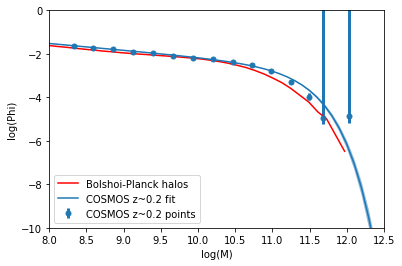

In [11]:
plot_SMF(sim_smf_mass_bins, sim_smf_log_phi, cosmos_data['cosmos_SMF_points_table'],
         cosmos_data['cosmos_SMF_fit_table'])

In [12]:
sim_wl_ds

array([112.11130602,  48.96603309,  93.34299271,  60.80819339,
        37.56459017,  22.40011544,  15.0303015 ,   8.89846034])

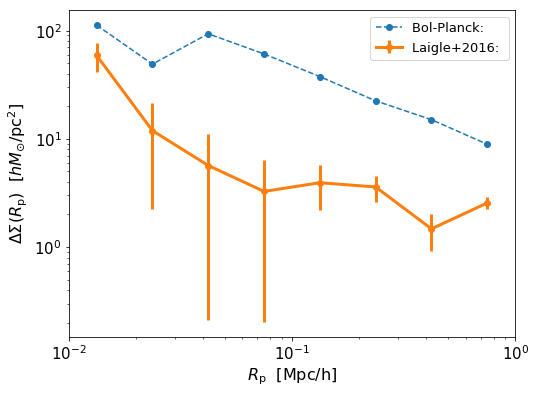

In [13]:
plot_deltaSigma(cosmos_data['cosmos_wl_table'], sim_wl_r, sim_wl_ds)

## probability functions

In [16]:
def flat_prior(param_tuple, param_low, param_upp):
    """Priors of parameters. Return -inf if all parameters are not within bounds."""
    if not np.all([low <= param <= upp for param, low, upp in
                   zip(list(param_tuple), param_low, param_upp)]):
        return -np.inf

    return 0.0

def smf_lnlike(obs_smf_fit_table, obs_smf_points_table, sim_smf_mass_bins, sim_smf_log_phi):
    """Calculate the likelihood for SMF."""
    
    #get same bins in simulations as in observations 
    sim_smf_log_phi_interpolated = np.interp(obs_smf_points_table['logM'], sim_smf_mass_bins, sim_smf_log_phi)
    
    #difference
    smf_diff = (np.array(sim_smf_log_phi_interpolated) - np.array(obs_smf_points_table['Phi']))
    
    #variance
    obs_mean_smf_error = np.mean([obs_smf_points_table['Phi_err+'] , obs_smf_points_table['Phi_err-'] ])
    smf_var = np.array(obs_mean_smf_error ** 2)

    #chi2
    smf_chi2 = (smf_diff ** 2 / smf_var).sum()

    #likelihood
    smf_lnlike = -0.5 * (smf_chi2 + np.log(2 * np.pi * smf_var).sum())


    # print("SMF Tot lnlike/chi2: %f,%f" % (smf_mtot_lnlike,
    #                                       smf_mtot_chi2))


    return smf_lnlike

def dsigma_lnlike(obs_wl_table, sim_wl_r, sim_wl_ds):
    """Calculate the likelihood for WL profile."""
    
    #make sure same bins
    decimal_places_to_round_bins = 5
    assert np.all(sim_wl_r.round(decimal_places_to_round_bins) == \
                  np.array(cosmos_data['cosmos_wl_table']['R(Mpc)']).round(decimal_places_to_round_bins))
    
    dsigma_obs = obs_wl_table['SigR(Msun/pc^2)']  
    dsigma_obs_err = obs_wl_table['err(weights)']

    dsigma_var = (dsigma_obs_err ** 2)
    dsigma_diff = (dsigma_obs - sim_wl_ds) ** 2

    dsigma_chi2 = (dsigma_diff / dsigma_var).sum()
    dsigma_lnlike = -0.5 * (dsigma_chi2 + np.log(2 * np.pi * dsigma_var).sum())
    # print("DSigma likelihood / chi2: %f, %f" % (dsigma_lnlike, dsigma_chi2))

    return dsigma_lnlike
def ln_like(param_tuple, config, obs_data, sim_data, chi2=False,
                 sep_return=False):
    """Calculate the lnLikelihood of the model."""
    # Unpack the input parameters
    parameters = list(param_tuple)

    # Generate the model predictions
    sim_smf_mass_bins, sim_smf_log_phi, sim_wl_r, sim_wl_ds = predict_model(parameters, config, obs_data, sim_data)   

    # Likelihood for SMFs.
    smf_lnlike_value = smf_lnlike(obs_data['cosmos_SMF_fit_table'], obs_data['cosmos_SMF_points_table'],
        sim_smf_mass_bins, sim_smf_log_phi)

    # Likelihood for DeltaSigma
    dsigma_lnlike_value = dsigma_lnlike(obs_data['cosmos_wl_table'], sim_wl_r, sim_wl_ds)

    if not np.isfinite(dsigma_lnlike_value):
        return -np.inf

    return smf_lnlike_value + config['mcmc_wl_weight'] * dsigma_lnlike_value

def ln_prob_global(param_tuple):
    """Probability function to sample in an MCMC.

    Parameters
    ----------
    param_tuple: tuple of model parameters.

    """
    print(param_tuple)
    
    lp = flat_prior(param_tuple, config['param_low'], config['param_upp'])

    if not np.isfinite(lp):
        return -np.inf

    print(lp + ln_like(param_tuple, config, cosmos_data, sim_data))
    return lp + ln_like(param_tuple, config, cosmos_data, sim_data)


In [15]:
dsigma_lnlike(cosmos_data['cosmos_wl_table'], sim_wl_r, sim_wl_ds)

-1197.9123312001027

In [16]:
smf_lnlike(cosmos_data['cosmos_SMF_fit_table'], cosmos_data['cosmos_SMF_points_table'],
           sim_smf_mass_bins, sim_smf_log_phi)

-5.119586259530056

In [13]:
%lprun -f predict_model ln_like(config['param_ini'], config, cosmos_data, sim_data)

## setup mcmc functions 

In [25]:
def mcmc_initial_guess(param_initial, param_sigma, n_walkers, n_dims):
    """Initialize guesses for the MCMC run. One guess for each dimension (model parameter) per walker,
    with a small sigma deviation from param_initial. """
    mcmc_position = np.zeros([n_walkers, n_dims])

    for ii, param_0 in enumerate(param_initial):
        mcmc_position[:, ii] = (param_0 + param_sigma[ii] * np.random.randn(n_walkers))

    return mcmc_position

def mcmc_setup_moves(config, move_col):
    """Choose the Move object for emcee."""
    if config[move_col] == 'snooker':
        emcee_moves = emcee.moves.DESnookerMove()
    elif config[move_col] == 'stretch':
        emcee_moves = emcee.moves.StretchMove(a=config['mcmc_stretch_a'])
    elif config[move_col] == 'walk':
        emcee_moves = emcee.moves.WalkMove()
    elif config[move_col] == 'kde':
        emcee_moves = emcee.moves.KDEMove()
    elif config[move_col] == 'de':
        emcee_moves = emcee.moves.DEMove(config['mcmc_de_sigma'])
    else:
        raise Exception("Wrong option: stretch, walk, kde, de, snooker")
    
    return emcee_moves

def mcmc_burnin(mcmc_sampler, mcmc_position, config, verbose=True):
    """Run the MCMC chain."""
    # Burn-in
    if verbose:
        print("# Phase: Burn-in ...")
    mcmc_burnin_result = mcmc_sampler.run_mcmc(
        mcmc_position, config['mcmc_nburnin'],
        progress=True)

    mcmc_save_results(mcmc_burnin_result, mcmc_sampler,
                      config['mcmc_burnin_file'], config['mcmc_ndims'],
                      verbose=True)

    # Rest the chains
    mcmc_sampler.reset()
    
    return mcmc_burnin_result
    
def emcee_run(mcmc_sampler, mcmc_burnin_result, config, verbose=True):
    """Run the MCMC chain."""
    mcmc_burnin_position, _, mcmc_burnin_state = mcmc_burnin_result

    if verbose:
        print("# Phase: MCMC run ...")
    mcmc_run_result = mcmc_sampler.run_mcmc(
        mcmc_burnin_position, config['mcmc_nsamples'],
        rstate0=mcmc_burnin_state,
        progress=True)

    mcmc_save_results(mcmc_run_result, mcmc_sampler,
                      config['mcmc_run_file'], config['mcmc_ndims'],
                      verbose=True)

    return mcmc_run_result

def mcmc_save_results(mcmc_results, mcmc_sampler, mcmc_file,
                      mcmc_ndims, verbose=True):
    """Save the MCMC run results."""
    (mcmc_position, mcmc_lnprob, _) = mcmc_results

    mcmc_samples = mcmc_sampler.chain[:, :, :].reshape(
        (-1, mcmc_ndims))
    mcmc_chains = mcmc_sampler.chain
    mcmc_lnprob = mcmc_sampler.lnprobability
    ind_1, ind_2 = np.unravel_index(np.argmax(mcmc_lnprob, axis=None),
                                    mcmc_lnprob.shape)
    mcmc_best = mcmc_chains[ind_2, ind_1, :]
#     mcmc_params_stats = mcmc_samples_stats(mcmc_samples)

    np.savez(mcmc_file,
             samples=mcmc_samples, lnprob=np.array(mcmc_lnprob),
             best=np.array(mcmc_best), chains=mcmc_chains,
             position=np.asarray(mcmc_position),
             acceptance=np.array(mcmc_sampler.acceptance_fraction))

    if verbose:
        print("#------------------------------------------------------")
        print("#  Mean acceptance fraction",
              np.mean(mcmc_sampler.acceptance_fraction))
        print("#------------------------------------------------------")
        print("#  Best ln(Probability): %11.5f" % np.max(mcmc_lnprob))
        print(mcmc_best)
        print("#------------------------------------------------------")
#         for param_stats in mcmc_params_stats:
#             print(param_stats)
#         print("#------------------------------------------------------")

    return


## run fit

In [26]:
#skip paralleization for now
def emcee_fit(config, verbose=True):
    
    print('{0} thread(s)'.format(config['mcmc_nthreads']))
    
    # Initialize the model
    mcmc_ini_position = mcmc_initial_guess(
        config['param_ini'], config['param_sig'], config['mcmc_nwalkers'],
        config['mcmc_ndims'])

    if config['mcmc_nthreads'] > 1:
        from multiprocessing import Pool
        from contextlib import closing

        with closing(Pool(processes=config['mcmc_nthreads'])) as pool:

            # Decide the Ensemble moves for walkers during burnin
            burnin_move = mcmc_setup_moves(config, 'mcmc_moves_burnin')

            burnin_sampler = emcee.EnsembleSampler(
                config['mcmc_nwalkers_burnin'],
                config['mcmc_ndims'],
                ln_prob_global,
                moves=burnin_move,
                pool=pool)

            # Burn-in
            mcmc_burnin_pos, mcmc_burnin_lnp, mcmc_burnin_state = mcmc_burnin(
                burnin_sampler, mcmc_ini_position, config, verbose=True)
            
            # Estimate the Kernel density distributions of final brun-in positions
            # Resample the distributions to get starting positions of the actual run
            mcmc_kde = gaussian_kde(np.transpose(mcmc_burnin_pos), 
                               bw_method='silverman')
            mcmc_new_pos = np.transpose(mcmc_kde.resample(config['mcmc_nwalkers']))

            mcmc_new_ini = (mcmc_new_pos, mcmc_burnin_lnp, mcmc_burnin_state)

            # TODO: Convergence test
            burnin_sampler.reset()

            # Change the moves
            # Decide the Ensemble moves for walkers during the official run
            mcmc_move = mcmc_setup_moves(config, 'mcmc_moves')

            mcmc_sampler = emcee.EnsembleSampler(
                config['mcmc_nwalkers'],
                config['mcmc_ndims'],
                ln_prob_global,
                moves=mcmc_move,
                pool=pool)

            # MCMC run
            mcmc_run_result = emcee_run(
                mcmc_sampler, mcmc_new_ini, config, verbose=True)
    else:
            
        # define the ensemble moves object for walkers during burn in
        burnin_move = mcmc_setup_moves(config, 'mcmc_moves_burnin')
        # define sampler
        burnin_sampler = emcee.EnsembleSampler(
            config['mcmc_nwalkers_burnin'],
            config['mcmc_ndims'],
            ln_prob_global,
            moves=burnin_move) #,pool=pool)

        # Burn-in
        mcmc_burnin_pos, mcmc_burnin_lnp, mcmc_burnin_state = mcmc_burnin(
            burnin_sampler, mcmc_ini_position, config, verbose=True)

        # Estimate the Kernel density distributions of final burn-in positions
        # Resample the distributions to get starting positions of the actual run
        mcmc_kde = gaussian_kde(np.transpose(mcmc_burnin_pos), 
                            bw_method='silverman')
        mcmc_new_pos = np.transpose(mcmc_kde.resample(config['mcmc_nwalkers']))

        mcmc_new_ini = (mcmc_new_pos, mcmc_burnin_lnp, mcmc_burnin_state)


        # MCMC run

        # Decide the Ensemble moves for walkers during burnin
        mcmc_move = mcmc_setup_moves(config, 'mcmc_moves')
        # define sampler
        mcmc_sampler = emcee.EnsembleSampler(config['mcmc_nwalkers'],
                                             config['mcmc_ndims'],
                                             ln_prob_global,
                                             moves=mcmc_move)

        mcmc_run_result = emcee_run(mcmc_sampler, mcmc_new_ini, config, verbose=True)

    return mcmc_run_result

In [27]:
emcee_fit(config)

1 thread(s)
# Phase: Burn-in ...
[0.3633381  0.28646553]
mock.populate
-1815.8024028650761
mock.populate
[0.45188291 0.18984182]
mock.populate
-916.2443010494915
mock.populate
[0.47923493 0.13382029]
mock.populate
-599.2207603065319
mock.populate
[0.40929034 0.33218148]
mock.populate
-1406.1290011813692
mock.populate


  0%|          | 0/5 [00:00<?, ?it/s]

[0.57604016 0.02818247]
mock.populate
-267.33123060427414
mock.populate
[0.50462632 0.22814697]
mock.populate
-559.4922889956187
mock.populate
[0.39920536 0.18603431]
mock.populate
-971.061305442813
mock.populate
[0.4583094  0.17184713]
mock.populate
-624.936349056317
mock.populate


 20%|██        | 1/5 [00:17<01:10, 17.72s/it]

[0.38868808 0.31727933]
mock.populate
-1100.6230835928864
mock.populate
[0.60516261 0.06358183]
mock.populate
-230.68808851259482
mock.populate
[ 0.70287025 -0.12512191]
[0.45735376 0.2855498 ]
mock.populate
-823.5137119034005
mock.populate


 40%|████      | 2/5 [00:30<00:49, 16.37s/it]

[0.42827566 0.20722344]
mock.populate
-908.0275159107767
mock.populate
[0.22908005 0.56439096]
mock.populate
-3112.255124117621
mock.populate
[0.49113093 0.18084171]
mock.populate
-515.4055497216259
mock.populate
[0.51034538 0.01017913]
mock.populate
-571.7225673350175
mock.populate


 60%|██████    | 3/5 [00:47<00:32, 16.46s/it]

[0.41595259 0.24172901]
mock.populate
-1170.9911533999327
mock.populate
[0.49804269 0.1614882 ]
mock.populate
-501.99682925135227
mock.populate
[0.61228066 0.01297154]
mock.populate
-246.8879135244263
mock.populate
[0.45390835 0.24943441]
mock.populate
-743.4166084466281
mock.populate


 80%|████████  | 4/5 [01:05<00:16, 16.98s/it]

[0.65371275 0.009206  ]
mock.populate
-157.4958132513484
mock.populate
[0.38956182 0.3496192 ]
mock.populate
-976.2172795534226
mock.populate
[0.44096313 0.18859124]
mock.populate
-1051.758602357342
mock.populate


100%|██████████| 5/5 [01:19<00:00, 16.05s/it]

[ 0.74312705 -0.17918301]
#------------------------------------------------------
#  Mean acceptance fraction 0.35000000000000003
#------------------------------------------------------
#  Best ln(Probability):  -173.09415
[0.65371275 0.009206  ]
#------------------------------------------------------
# Phase: MCMC run ...
[0.43900552 0.30488785]


mock.populate
-905.9752263227904
mock.populate
[0.46874626 0.29453097]
mock.populate
-657.5398600318459
mock.populate
[0.54303062 0.17024136]
mock.populate
-369.689704828677
mock.populate
[0.56162939 0.07585374]
mock.populate
-347.78071450867014
mock.populate


  0%|          | 0/5 [00:00<?, ?it/s]

[0.51817044 0.2022176 ]
mock.populate
-410.03808755684963
mock.populate
[0.41881254 0.40225309]
mock.populate
-995.6264678665443
mock.populate
[0.41847731 0.33129213]
mock.populate
-894.861582589442
mock.populate
[0.59214502 0.03660322]
mock.populate
-245.78022906725903
mock.populate


 20%|██        | 1/5 [00:19<01:17, 19.40s/it]

[0.46488537 0.20501783]
mock.populate
-838.7402864082977
mock.populate
[0.56992108 0.06140636]
mock.populate
-383.65295693377436
mock.populate
[0.62838742 0.05353614]
mock.populate
-208.93409793363682
mock.populate
[0.55737156 0.08414769]
mock.populate
-346.8290380354369
mock.populate


 40%|████      | 2/5 [00:39<00:58, 19.52s/it]

[ 0.67728602 -0.07890881]
[ 0.71396334 -0.05830298]
[0.42846422 0.20992053]
mock.populate
-885.3540294172079
mock.populate
[0.63881183 0.07318492]
mock.populate
-166.10222317773136
mock.populate


 60%|██████    | 3/5 [00:48<00:33, 16.52s/it]

[0.54039987 0.08875723]
mock.populate
-388.1741882963328
mock.populate
[0.44957405 0.24851031]
mock.populate
-720.6706653491033
mock.populate
[0.51006122 0.19786939]
mock.populate
-441.79610965244126
mock.populate
[0.67476366 0.04619775]
mock.populate
-185.27067336589556
mock.populate


 80%|████████  | 4/5 [01:08<00:17, 17.40s/it]

[0.4842177  0.20195876]
mock.populate
-537.4330010351193
mock.populate
[0.68591757 0.0444328 ]
mock.populate
-146.12776268859804
mock.populate
[0.45288754 0.16511269]
mock.populate
-859.4843819976824
mock.populate
[0.67279592 0.04353342]
mock.populate
-157.88321004050582
mock.populate


100%|██████████| 5/5 [01:27<00:00, 17.98s/it]

#------------------------------------------------------
#  Mean acceptance fraction 0.6499999999999999
#------------------------------------------------------
#  Best ln(Probability):  -147.14832
[0.67279592 0.04353342]
#------------------------------------------------------


State([[0.51006122 0.19786939]
 [0.54039987 0.08875723]
 [0.68591757 0.0444328 ]
 [0.67279592 0.04353342]], log_prob=[-443.07406353 -330.84375557 -152.16892466 -147.148324  ], blobs=None, random_state=('MT19937', array([1940153125,  569719204, 1649896046, 2289773569, 2977730530,
       1488586343, 4107724012, 2442213841, 1161870999,  329689792,
       2325320556, 1229611746, 3687903408, 1768607378, 3653454347,
       1259077348, 2822407516,  153957682, 1550020162, 4112389646,
       3253383222, 1515517062, 4291890710, 3656820647, 2774598390,
       1672497750,   37039001, 1159405146, 1215189630, 3787949277,
       3033018429,  702680791, 1556636834, 1944874773, 2299434671,
       1522996926, 2501924058, 1627345783, 2860912300, 1194689426,
       3866668224, 1866967486, 1097000039, 2214222174, 1622260343,
       2558659479, 2077897110, 2621779931, 3820690914, 1893608077,
       1439553695, 1634572292, 3223483684, 1256207162, 1348045761,
       1610853206, 1273159227, 1196783657, 1469583

In [14]:
params = [0.32200022, 0.26710406]

ln_prob_global(param_tuple=params)

[0.32200022, 0.26710406]
mock.populate


-2047.0922560036606

10/8: successfully implemented mock.populate. parallelization works in notebook, not well in standalone script. still some bugs like the one above (not parallel)